### 1. Setup and load data
#### 1.1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os
resArray = ["Danger", "Order", "Other"]

In [2]:
os.listdir()
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#### 1.2. Remove dodgy images

#### 1.3. Load data

In [3]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = tf.keras.utils.image_dataset_from_directory('Data', batch_size= 8)

Found 116 files belonging to 3 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
# Get another batch of data
batch = data_iterator.next()

In [8]:
#Images represented as numpy arrays
batch[0].shape

(8, 256, 256, 3)

In [9]:
# Class 1 = Orders
# Class 0 = Danger
batch[1]

array([0, 1, 1, 2, 2, 2, 1, 2])

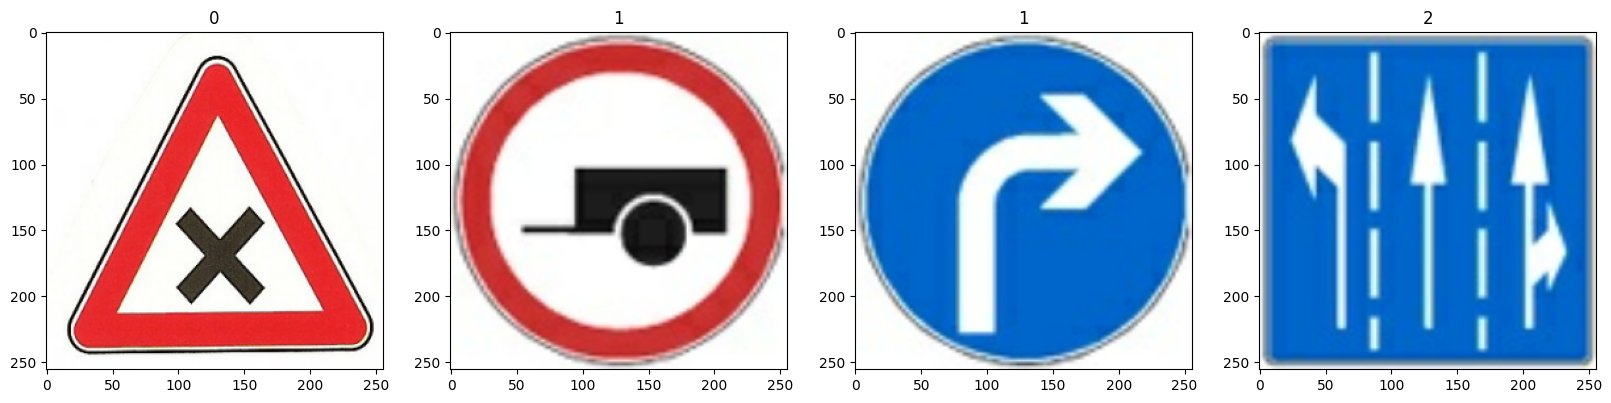

In [10]:
fig, ax = plt.subplots(ncols=4,  figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    # ax[idx].set_xticks([])
    # ax[idx].set_yticks([])

In [11]:
scaled = batch[0] / 255


In [12]:
scaled.max()

1.0

### 2. Preproccess Data
#### 2.1.Scale Data

In [13]:
data = data.map(lambda x, y: (x / 255, y))

In [14]:
data.as_numpy_iterator().next()[0].max()
batch = data.as_numpy_iterator().next()

In [15]:
batch[0].max()

1.0

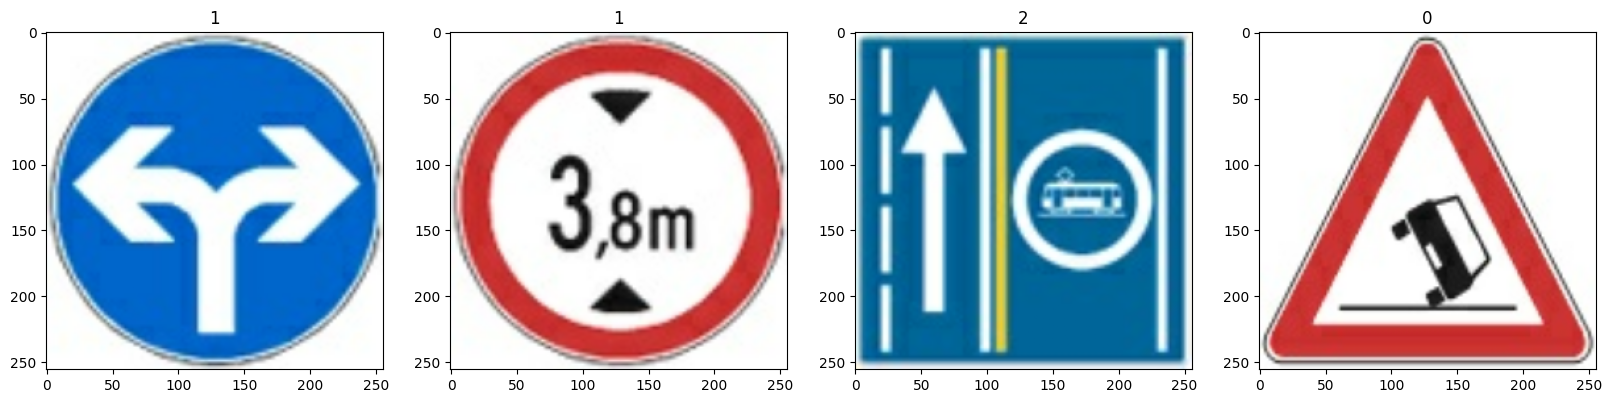

In [16]:
fig, ax = plt.subplots(ncols=4,  figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])
    # ax[idx].set_xticks([])
    # ax[idx].set_yticks([])

#### 2.2. Split Data

In [17]:
len(data)

15

In [18]:
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data)) + 1
test_size = int(0.1 * len(data)) + 1 

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [20]:
len(train), len(val), len(test)

(10, 4, 1)

### 3. Deep model
#### 3.1. Build Deep Learning Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [22]:
model = Sequential()

In [23]:
MaxPooling2D??

Init signature:
MaxPooling2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs,
)
Source:        
@keras_export("keras.layers.MaxPool2D", "keras.layers.MaxPooling2D")
class MaxPooling2D(Pooling2D):
    """Max pooling operation for 2D spatial data.

    Downsamples the input along its spatial dimensions (height and width)
    by taking the maximum value over an input window
    (of size defined by `pool_size`) for each channel of the input.
    The window is shifted by `strides` along each dimension.

    The resulting output,
    when using the `"valid"` padding option, has a spatial shape
    (number of rows or columns) of:
    `output_shape = math.floor((input_shape - pool_size) / strides) + 1`
    (when `input_shape >= pool_size`)

    The resulting output shape when using the `"same"` padding option is:
    `output_shape = math.floor((input_shape - 1) / strides) + 1`

    For example, for `strides=(1, 1)` and `padding="valid"`:

    >>

In [24]:
# train_labels_encoded = to_categorical([0,1,2], num_classes=3)
# val_labels_encoded = to_categorical([0,1,2], num_classes=3)

train_labels = [0,1,2]
val_labels = [0,1,2]

In [25]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

In [26]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### 3.2. Train

In [28]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [29]:
hist = model.fit(train, validation_data=val, epochs=20, callbacks=[tensorboard_callback])


Epoch 1/20
10/10 [==============================] - 3s 231ms/step - loss: 1.2103 - accuracy: 0.5375 - val_loss: 0.5444 - val_accuracy: 0.8438
Epoch 2/20
10/10 [==============================] - 2s 202ms/step - loss: 0.3391 - accuracy: 0.9375 - val_loss: 0.1516 - val_accuracy: 0.9688
Epoch 3/20
10/10 [==============================] - 2s 221ms/step - loss: 0.0660 - accuracy: 0.9875 - val_loss: 0.1015 - val_accuracy: 0.9688
Epoch 4/20
10/10 [==============================] - 2s 202ms/step - loss: 0.0777 - accuracy: 0.9750 - val_loss: 0.0365 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 2s 203ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 2s 198ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 2.4905e-04 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 2s 196ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Ep

In [30]:
hist.history

{'loss': [1.2103468179702759,
  0.3391263484954834,
  0.06596006453037262,
  0.07767321169376373,
  0.0035815301816910505,
  0.019279712811112404,
  0.005700110457837582,
  0.0009791516931727529,
  0.000412095250794664,
  0.00019871180120389909,
  6.946107896510512e-05,
  8.450259338133037e-05,
  6.836374814156443e-05,
  6.556768494192511e-05,
  3.0886538297636434e-05,
  4.2608917283359915e-05,
  2.6041307137347758e-05,
  1.783204425009899e-05,
  3.50879090547096e-05,
  1.4219711374607868e-05],
 'accuracy': [0.5375000238418579,
  0.9375,
  0.987500011920929,
  0.9750000238418579,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.544404149055481,
  0.1515757441520691,
  0.10153765231370926,
  0.03650712966918945,
  0.025662092491984367,
  0.0002490525075700134,
  0.002324006287381053,
  0.0007526044500991702,
  0.00025749922497197986,
  8.242124749813229e-05,
  9.918559953803197e-05,
  8.102358697215095e-05,


#### 3.3. Plot Performance

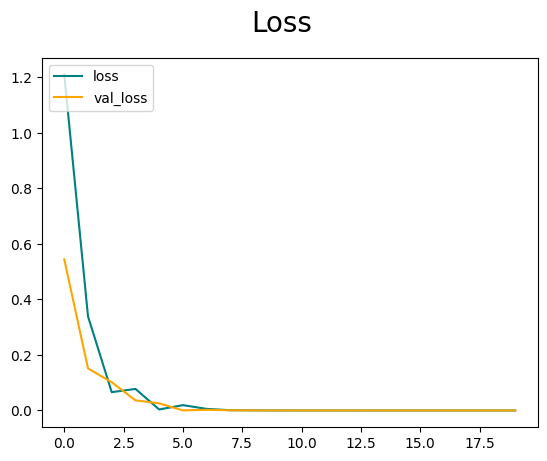

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss', color='teal')
plt.plot(hist.history['val_loss'], label='val_loss', color='orange')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

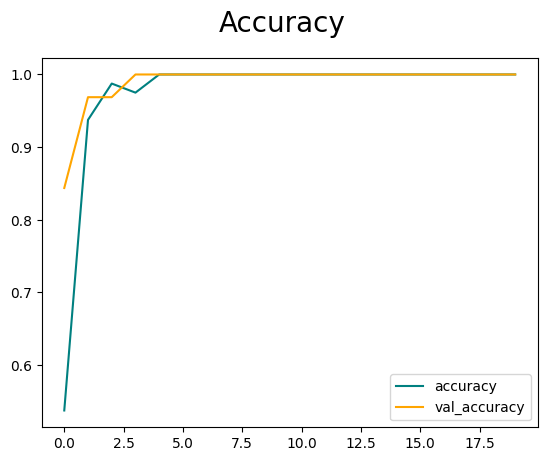

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label='accuracy', color='teal')
plt.plot(hist.history['val_accuracy'], label='val_accuracy', color='orange')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='lower right')
plt.show()

### 4. Evaluate performance
#### 4.1. Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [35]:
# for batch in test.as_numpy_iterator():
#     X,y = batch
#     yhat = model.predict(X)
#     pre.update_state(y, yhat)
#     rec.update_state(y, yhat)
#     acc.update_state(y, yhat)

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    # Reshape yhat to match the shape of y
    yhat = tf.argmax(yhat, axis=1)
    
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 112ms/step


In [36]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {rec.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 0.5


#### 4.2. Test

In [37]:
import cv2

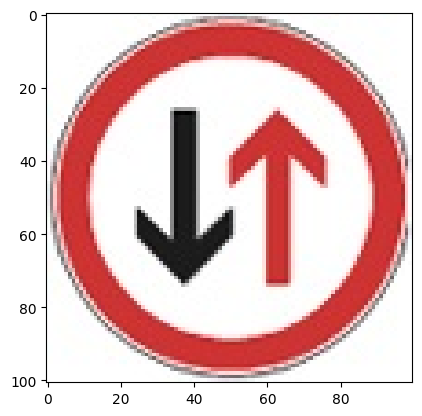

In [38]:
img = cv2.imread('Images/image_2134.jpg')
imgAsRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgAsRGB)
plt.show()


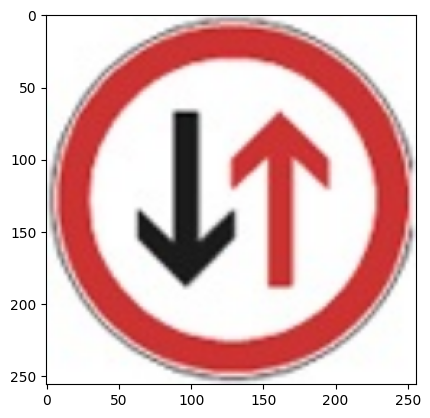

In [39]:
resize = tf.image.resize(imgAsRGB, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [40]:
resize.shape

TensorShape([256, 256, 3])

In [41]:
np.expand_dims(resize, axis=0).shape

(1, 256, 256, 3)

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [43]:
yhat

array([[1.5298149e-10, 1.0000000e+00, 2.8746439e-12]], dtype=float32)

In [44]:
max_index = np.argmax(yhat, axis=1)
resArray[max_index[0]]

'Order'

### 5. Save the model
#### 5.1. Save the model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model.save(os.path.join('models', 'DangerVsOrder.h5'))

In [47]:
new_model = load_model(os.path.join('models', 'DangerVsOrder.h5'))

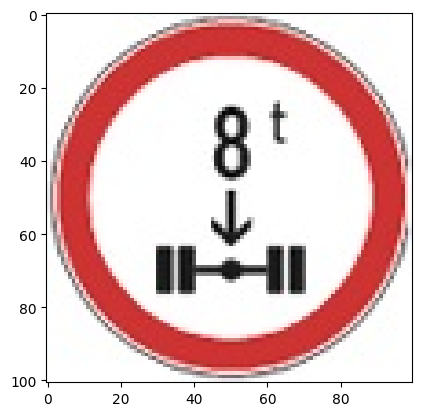

In [77]:
img = cv2.imread('Images/image_2036.jpg')
imgAsRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgAsRGB)
plt.show()

In [78]:
resize = tf.image.resize(imgAsRGB, (256, 256))

In [79]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
yhatnew

1/1 [==============================] - 0s 24ms/step


array([[6.4921894e-11, 1.0000000e+00, 5.1047057e-12]], dtype=float32)

In [80]:
max_index = np.argmax(yhatnew, axis=1)
resArray[max_index[0]]

'Order'